In [1]:
# Libraries
! wandb login $secret_value_0
!pip install wandb
import wandb
import pandas as pd
import numpy as np
import re
import os
import string
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS as stopwords_wc
from statsmodels.tsa.stattools import adfuller       ### Augmented Dickey Fuller
#!pip install cupy
get_ipython().system('pip install cupy')
import cupy
#!pip install cudf
get_ipython().system('pip install cudf')
import cudf

import cuml
from cuml.tsa.arima import ARIMA

# Color palette
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'
    
# W&B
os.environ["WANDB_SILENT"] = "true"
# Secrets 🤫
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

Traceback (most recent call last):
  File "C:\Users\sneha\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\sneha\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\sneha\anaconda3\Scripts\wandb.exe\__main__.py", line 7, in <module>
    sys.exit(cli())
  File "C:\Users\sneha\anaconda3\lib\site-packages\click\core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\sneha\anaconda3\lib\site-packages\click\core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "C:\Users\sneha\anaconda3\lib\site-packages\click\core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\sneha\anaconda3\lib\site-packages\click\core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "C:\Users\sneha\anaconda3\lib\site-packages\click\core.py", line 754, in invoke
    return __callbac

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\sneha\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sneha\\AppData\\Local\\Temp\\pip-install-raxzt6dd\\cupy_eda554613f914b8ea3110116ea5bd7ee\\setup.py'"'"'; __file__='"'"'C:\\Users\\sneha\\AppData\\Local\\Temp\\pip-install-raxzt6dd\\cupy_eda554613f914b8ea3110116ea5bd7ee\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\sneha\AppData\Local\Temp\pip-wheel-kb6wk8c2'
       cwd: C:\Users\sneha\AppData\Local\Temp\pip-install-raxzt6dd\cupy_eda554613f914b8ea3110116ea5bd7ee\
  Complete output (52 lines):
  
  -------- Configuring Module: cuda --------
  Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft 

  Using cached cupy-11.2.0.tar.gz (1.8 MB)
  Running setup.py clean for cupy
Failed to build cupy
    Running setup.py install for cupy: started
    Running setup.py install for cupy: finished with status 'error'


ModuleNotFoundError: No module named 'cupy'

In [2]:
def offset_png(x, y, path, ax, zoom, offset):
    '''For adding other .png images to the graph.
    source: https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib'''
    
    img = plt.imread(path)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)
    

    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        


def emoji_extractor(string, remove=False):
    '''Removes Emoji from a text.'''
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    if remove == False:
        # Extract emoji
        return emoji_pattern.findall(string)
    else:
        # Remove emoji from text
        return emoji_pattern.sub(r'', string)

def clean_emoji(x):
    if len(x) == 0:
        return ''
    else:
        return x[0]
    
    
    
def clean_tweets(df):
    '''Returns the dataframe with the tweet column cleaned.'''
    
    # ----- Remove \n, \t, \xa0 -----
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\xa0', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ''))
    
    # ----- Remove pic.twitter and http:// + https:// links -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'pic.twitter\S+', '', x))
    
    # ----- Remove mentions and hashtags -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
    
    # ----- Extract Emojis and Remove from Tweet -----
    df['tweet_emojis'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=False))
    df['tweet_emojis'].replace('', np.nan, inplace=True)
#     df["tweet_emojis"] = df["tweet_emojis"].apply(lambda x: clean_emoji(x))
    
    df['tweet'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=True))
    
    # ----- Strip of whitespaces -----
    df['tweet'] = df['tweet'].apply(lambda x: x.strip())
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x.split()))
    
    # ----- Remove punctuation & Make lowercase -----
    df['tweet'] = df['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    return df

# Elon Musk's personality


* Let's see how his tweets look, his tweets progression over time and get an overall feel of how, what, when he tweets.
This will help us understand about his behavior, as well as address and analyse the tweets that mention Bitcoin.

In [3]:
# === Tweets ===
tweets = pd.read_csv("TweetsElonMusk.csv")
tweets = tweets[["id", "date", "time", "username", 
                 "tweet", "mentions", "urls", "photos", "replies_count", 
                 "retweets_count", "likes_count", "hashtags", "link"]]

# Create new features
tweets["year"] = tweets["date"].apply(lambda x: x.split("-")[0])
# Clean Tweets
tweets = clean_tweets(df=tweets)


Text(0, 0.5, 'Frequency')

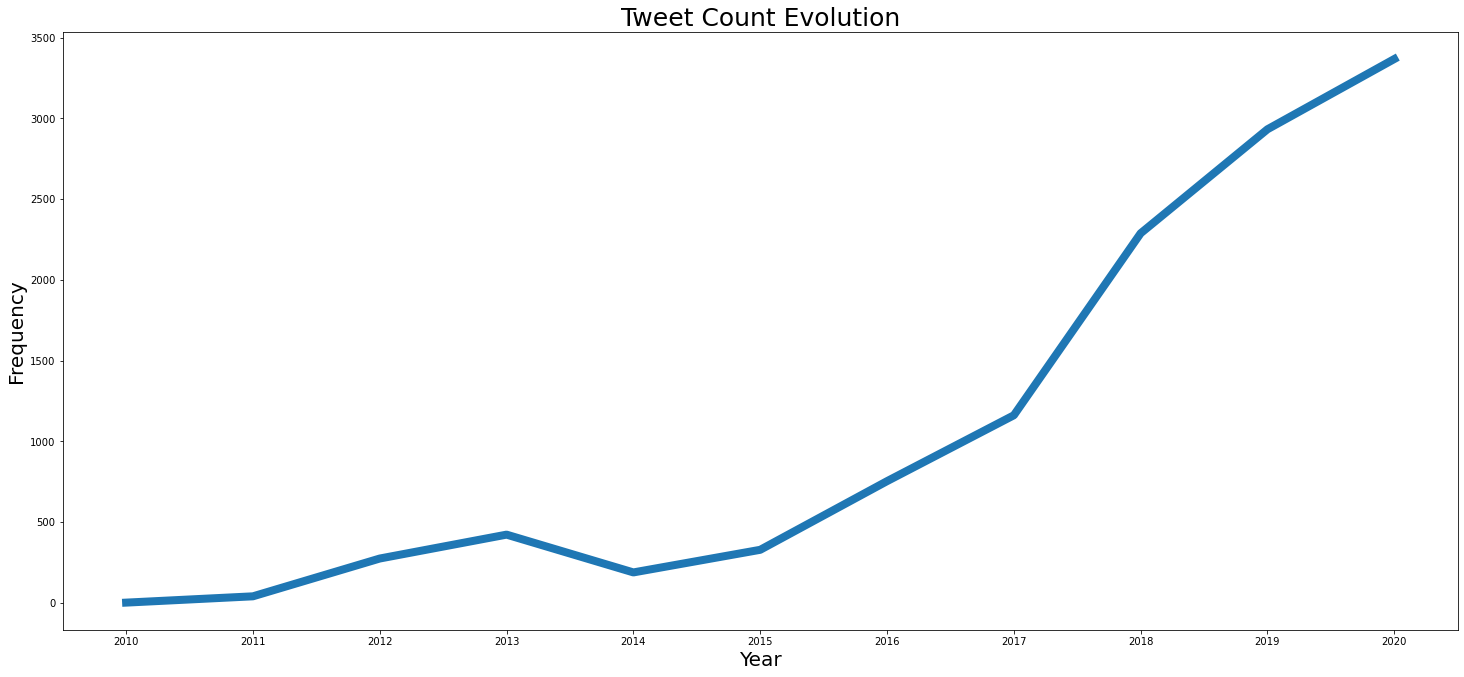

In [4]:
# Yearly evolution
date_count_df = tweets[tweets["year"]!="2021"].groupby("year")["tweet"].count().reset_index()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.lineplot(data=date_count_df, x="year", y="tweet", lw=8)
plt.title("Tweet Count Evolution", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Frequency", size=20)


# * We want to explore more about his personality. We want to plot his like counts, retweets count and replies counts 

In [5]:
def create_wandb_lineplot(x_data, y_data, x_name, y_name, title, log):
    '''Create and save barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    # Save Graph in W&B Dashboard as well
    data = [[label, val] for (label, val) in zip(x_data, y_data)]

    table = wandb.Table(data=data, columns = [x_name, y_name])
    wandb.log({log : wandb.plot.line(table, x_name, y_name,
                                                  title=title)})

In [ ]:
# Get Popularity Information
popularity = ["likes_count", "retweets_count", "replies_count"]
popularity_df = tweets[tweets["year"]!="2021"].groupby("year").agg({popularity[0] : 'sum',
                                                                    popularity[1] : 'sum',
                                                                    popularity[2] : 'sum',
                                                                    'tweet' : 'count'}).reset_index()
popularity_df["likes_count"] = popularity_df["likes_count"]/popularity_df["tweet"]
popularity_df["retweets_count"] = popularity_df["retweets_count"]/popularity_df["tweet"]
popularity_df["replies_count"] = popularity_df["replies_count"]/popularity_df["tweet"]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(25, 15))
axs = [ax1, ax2, ax3]
plt.suptitle("Popularity", size=25)
sns.barplot(data=popularity_df, x="year", y="likes_count", lw=5, ax=ax1)
sns.barplot(data=popularity_df, x="year", y="retweets_count", lw=5,  ax=ax2)
sns.barplot(data=popularity_df, x="year", y="replies_count", lw=5,  ax=ax3)
names = ["Average Likes", "Average Retweets", "Average Replies"]
for ax, n in zip(axs, names):
    ax.set_xlabel("", size=20)
    ax.set_ylabel(n, size=20)
    ax.get_yaxis().set_ticks([])
#     ax.title.set_text(n)
    show_values_on_bars(axs=ax, h_v="v", space=0.4)
sns.despine(left=True);

In [6]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, mask=None, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "Comment", "text", "attr", "object"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,mask=mask, background_color="white").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()    

# Most Frequent Words

In [7]:
def create_wandb_barplot(x_data, y_data, x_name, y_name, title, log):
    '''Create and save barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    # Save Graph in W&B Dashboard as well
    data = [[label, val] for (label, val) in zip(x_data, y_data)]

    table = wandb.Table(data=data, columns = [x_name, y_name])
    wandb.log({log : wandb.plot.bar(table, x_name, y_name,
                                                  title=title)})

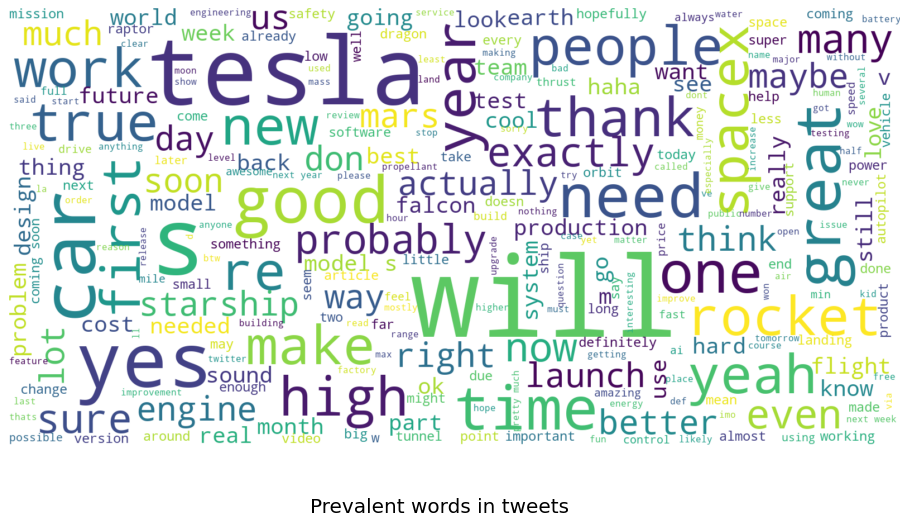

In [8]:
show_wordcloud(tweets['tweet'], title = 'Prevalent words in tweets')

In [9]:
# Retrieve Bitcoin Information
bitcoin_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)

# Information
print("% of tweets about Bitcoin:", "{:.3}%".format(bitcoin_tweets.shape[0]/tweets.shape[0]*100))
top = bitcoin_tweets.sort_values("likes_count", ascending=False)[:10]["tweet"]
print("Most liked BITCOIN tweets:")
for k, text in enumerate(top):
    print(f"{k+1}. {text}")
    


% of tweets about Bitcoin: 0.111%
Most liked BITCOIN tweets:
1. you can now buy a tesla with bitcoin
2. btc bitcoin is an anagram of tbcthe boring company what a coincidence
3. bitcoin is my safe word
4. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
5. pay by bitcoin capability available outside us later this year
6. bitcoin is almost as bs as fiat money
7. bitcoin is not my safe word
8. toss a bitcoin to ur witcher
9. to be clear i am not an investor i am an engineer i don’t even own any publicly traded stock besides tesla however when fiat currency has negative real interest only a fool wouldn’t look elsewhere bitcoin is almost as bs as fiat money the key word is “almost”
10. tesla’s action is not directly reflective of my opinion having some bitcoin which is simply a less dumb form of liquidity than cash is adventurous enough for an sampp500 company


In [10]:
# Retrieve only dogecoin Information
dogecoin_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)

# Information
print("% of tweets about Dogecoin:", "{:.3}%".format(dogecoin_tweets.shape[0]/tweets.shape[0]*100))
  
top = dogecoin_tweets.sort_values("likes_count", ascending=False)[:10]["tweet"]
print("Most liked DOGECOIN tweets:")
for k, text in enumerate(top):
    print(f"{k+1}. {text}")



% of tweets about Dogecoin: 0.0796%
Most liked DOGECOIN tweets:
1. dogecoin is the people’s crypto
2. bought some dogecoin for lil x so he can be a toddler hodler
3. spacex is going to put a literal dogecoin on the literal moon
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. dogecoin rulz
6. origin of doge day afternoon the ancient romans sacrificed a dogecoin at the beginning of the doge days to appease the rage of sirius believing that the star was the cause of the hot sultry weather
7. dogecoin value may vary
8. 2022 dogecoin is dumb
9. dogecoin might be my fav cryptocurrency it’s pretty cool
10. dogecoin mode


In [11]:
# === Dogecoin ===
dogecoin = pd.read_csv("DOGE-USD.csv")

# Is there correlation between Dogecoin and Elon Musk's Tweets?

In [12]:
dogecoin .head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0


In [13]:
dogecoin .columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [14]:
dogecoin.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,0.059575,0.063096,0.056126,0.059619,0.059619,1.016258e+09
std,0.101325,0.109152,0.093695,0.101379,0.101379,3.563999e+09
min,0.001046,0.001210,0.001002,0.001038,0.001038,1.431720e+06
25%,0.002550,0.002616,0.002500,0.002548,0.002548,2.307671e+07
50%,0.003476,0.003603,0.003356,0.003495,0.003495,8.981855e+07
75%,0.070633,0.075035,0.068478,0.070657,0.070657,6.565853e+08
max,0.687801,0.737567,0.608168,0.684777,0.684777,6.941068e+10


In [15]:
dogecoin .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1761 non-null   object 
 1   Open       1760 non-null   float64
 2   High       1760 non-null   float64
 3   Low        1760 non-null   float64
 4   Close      1760 non-null   float64
 5   Adj Close  1760 non-null   float64
 6   Volume     1760 non-null   float64
dtypes: float64(6), object(1)
memory usage: 96.4+ KB


# Analyze dogecoin Evolution

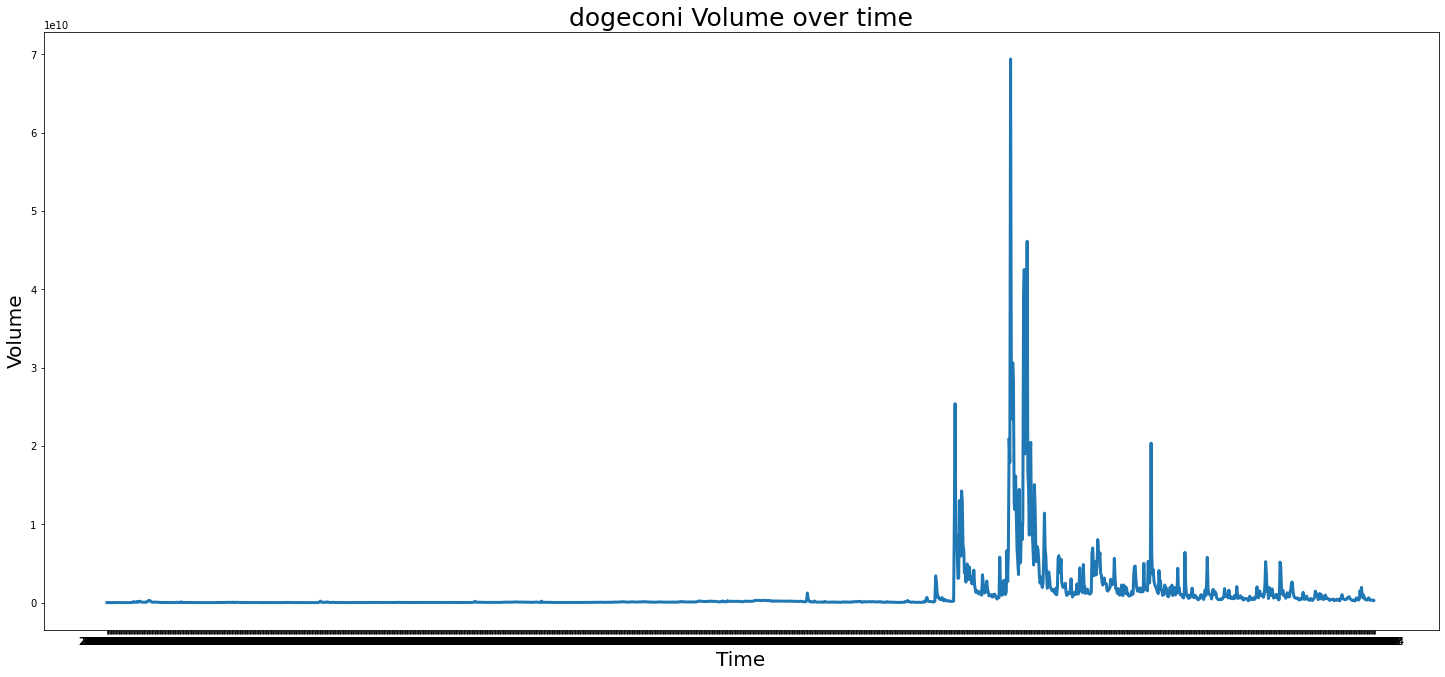

In [16]:
plt.figure(figsize = (25, 11))
plt.plot(dogecoin["Date"], dogecoin["Volume"], lw=3)
plt.title("dogeconi Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

1. spacex is going to put a literal dogecoin on the literal moon
2. origin of doge day afternoon the ancient romans sacrificed a dogecoin at the beginning of the doge days to appease the rage of sirius believing that the star was the cause of the hot sultry weather
3. 2022 dogecoin is dumb
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. bought some dogecoin for lil x so he can be a toddler hodler
6. dogecoin is the people’s crypto
7. dogecoin mode
8. dogecoin value may vary
9. dogecoin rulz
10. dogecoin might be my fav cryptocurrency it’s pretty cool


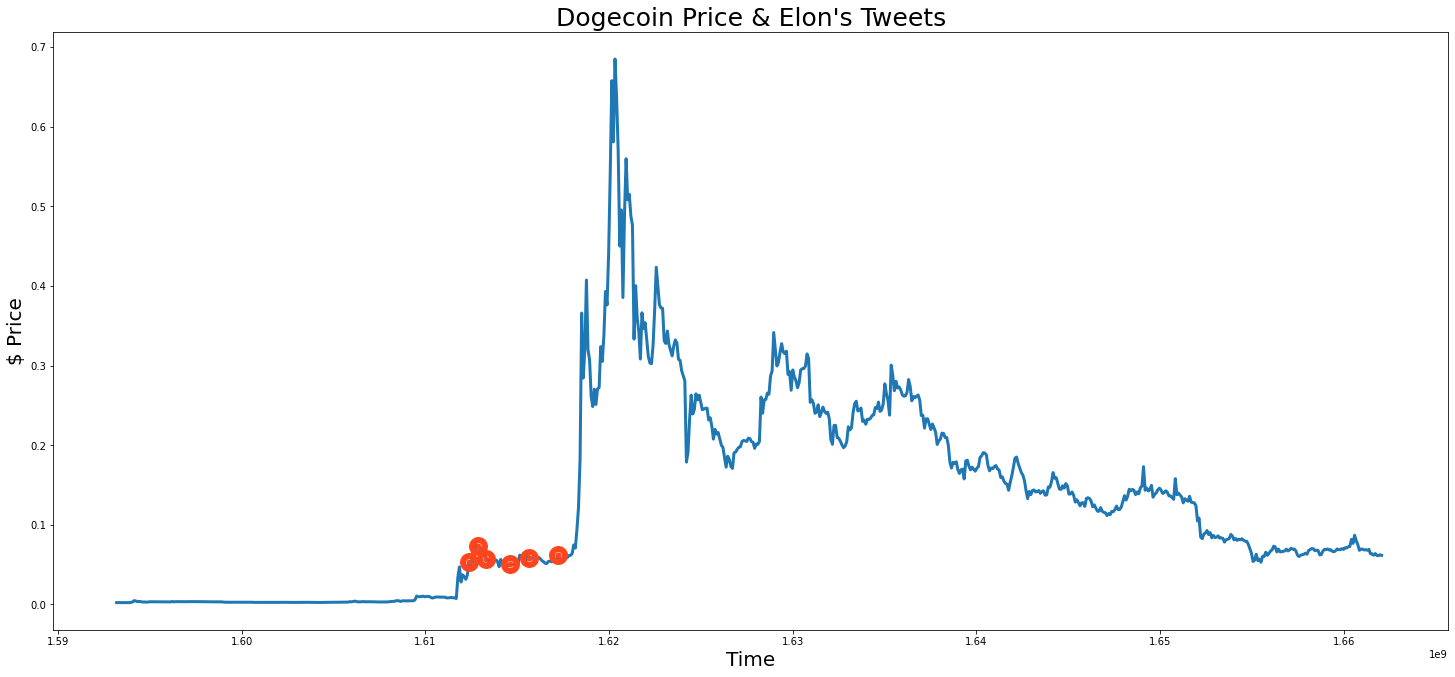

In [17]:
# Get bitcoin info
dgc_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)
# Convert date to number
dgc_tweets["date"] = dgc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
timestamps = dgc_tweets["date"]

dgc_prices = dogecoin.sort_values("Date", ascending=False).head(800)
dgc_prices["Date"] = dgc_prices["Date"].apply(lambda x: datetime.fromisoformat(x).timestamp())

for k, tweet in enumerate(dgc_tweets["tweet"]): print(f"{k+1}.", tweet)

# Get intersection
x_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Date"]
y_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Adj Close"]

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(dgc_prices["Date"], dgc_prices["Adj Close"], lw=3, zorder=1)
plt.title("Dogecoin Price & Elon's Tweets", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

* Closer look

1. spacex is going to put a literal dogecoin on the literal moon
2. origin of doge day afternoon the ancient romans sacrificed a dogecoin at the beginning of the doge days to appease the rage of sirius believing that the star was the cause of the hot sultry weather
3. 2022 dogecoin is dumb
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. bought some dogecoin for lil x so he can be a toddler hodler
6. dogecoin is the people’s crypto


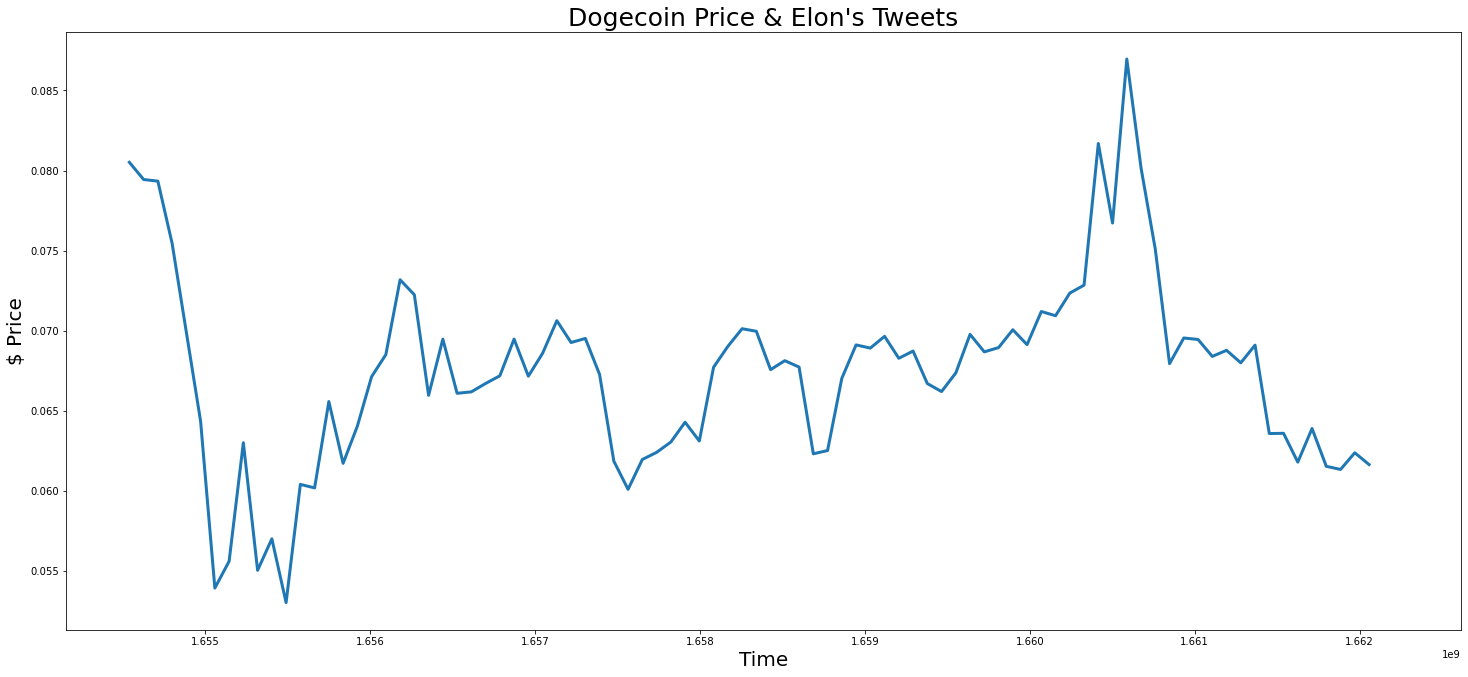

In [18]:
dgc_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)
# Convert date to number
dgc_tweets["date"] = dgc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
timestamps = dgc_tweets["date"]

dgc_prices = dogecoin.sort_values("Date", ascending=False).head(90)
dgc_prices["Date"] = dgc_prices["Date"].apply(lambda x: datetime.fromisoformat(x).timestamp())

for k, tweet in enumerate(dgc_tweets["tweet"][:6]): print(f"{k+1}.", tweet)

# Get intersection
x_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Date"]
y_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Adj Close"]

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(dgc_prices["Date"], dgc_prices["Adj Close"], lw=3, zorder=1)
plt.title("Dogecoin Price & Elon's Tweets", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

# Analyze time series data for dogecoin

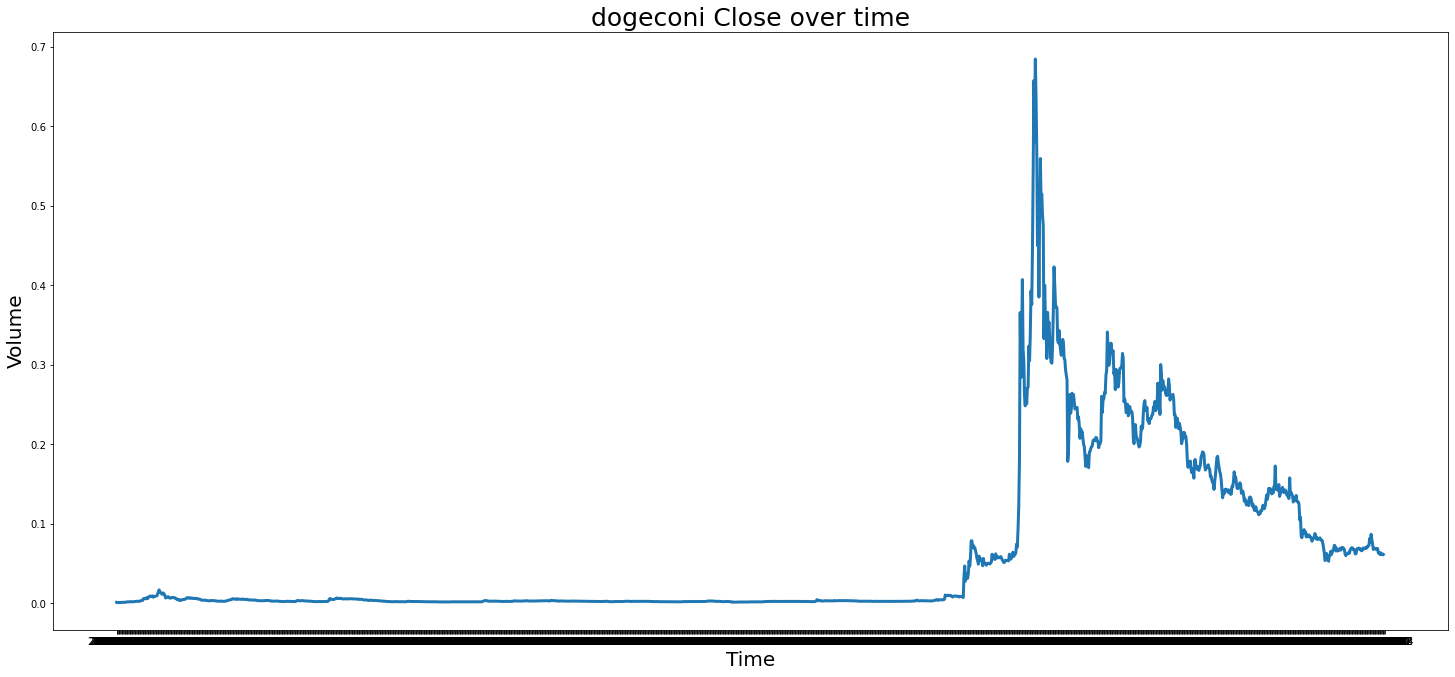

In [19]:
plt.figure(figsize = (25, 11))
plt.plot(dogecoin["Date"], dogecoin["Close"], lw=3)
plt.title("dogeconi Close over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

# Test Stationarity for the time series data dogecoin

Our time series data can have a trend or not. It is of the utmost importance to determine how the series is behaving before applying any model to it.

Augmented Dicky Fuller test: it determines how strongly a time series is defined by a trend.

Hypothesis:

Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.
Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Why is Stationarity Important?
For data to be stationary, the statistical properties of a system do not change over time. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant.

If the data is non-stationary (meaning it has a trend), we need to remove it in order to proceed with the analysis.